In [1]:
import glob
import numpy as np
import scipy as sp
import einops as eo
import matplotlib.pyplot as plt
import math
from scipy.spatial.transform import Rotation

M0 = 1480 #mT
shape = [3*25.4/16, 25.4/8] #radius and height
x0 = np.array([0,0,10, 0,0,1])


In [2]:
def B_dipole(position, rotation, M0, shape):
    R = np.sqrt(np.sum(position**2, axis=1))
    B = (M0 * (shape[0]) ** 2 * shape[1] / (16)) * (
        (
            3
            * position
            / R[:, np.newaxis] ** 5
            * (eo.einsum(position, rotation, "sensor dim,  dim -> sensor"))[
                :, np.newaxis
            ]
        )
        - rotation[np.newaxis, :] / (R[:, np.newaxis] ** 3)
    )
    return B


def getField_dipole(x, positions, M0, shape):
    position = x[:3]
    axis = x[3:]
    return B_dipole(positions - position, axis, M0, shape)


def getField_dipole_fixed(x, positions, M0, shape):
    position = x[:3]
    axis = x[3:]
    return B_dipole(positions - position, axis, M0, shape)


def cost_dipole(x, B, positions, M0, shape):
    diff = getField_dipole(x, positions, M0, shape) - B
    return np.sum((diff) ** 2)


def minimize(x0, B, positions, M0, shape, *args):
    #print("Starting mimimization")
    b_args = (B, positions, M0, shape)
    cons = [{"type": "eq", "fun": lambda x: x[3] ** 2 + x[4] ** 2 + x[5] ** 2 - 1}]
    bounds = [(-100, 100), (-100, 100), (0, 100), (-1, 1), (-1, 1), (-1, 1)]
    res = sp.optimize.minimize(
        fun=cost_dipole, x0=x0, args=b_args, tol=1e-100, constraints=cons, bounds=bounds, *args
    ).x  
    #print(f"Finished mimimization with shape {b_args[3]} at {res}")
    return res

def circle_radius(x1, y1, x2, y2, x3, y3):
    # Calculate lengths of sides of the triangle formed by the three points
    a = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    b = math.sqrt((x3 - x2) ** 2 + (y3 - y2) ** 2)
    c = math.sqrt((x3 - x1) ** 2 + (y3 - y1) ** 2)

    # Calculate the semi-perimeter of the triangle
    s = (a + b + c) / 2

    # Calculate the area of the triangle using Heron's formula
    area = math.sqrt(s * (s - a) * (s - b) * (s - c))

    # Calculate the radius of the circle using the formula: radius = (abc) / (4 * area)
    radius = (a * b * c) / (4 * area)
    
    return radius

def comparison_plot(locact, locpred, axis, relative):

    if axis == 'x':
        ax = 0
    elif axis == 'y':
        ax = 1
    else:
        ax = 2

    index = list(range(len(locact[:,ax])))
    act = locact[:, ax]
    pred = locpred[:, ax]

    rel = ''

    if relative==True:
        act = [x - locact[0, ax] for x in locact[:, ax]]
        pred = [x - locpred[0, ax] for x in locpred[:, ax]]
        rel = ' (Relative)'

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.scatter(index, pred, label='Predicted' + rel)
    plt.scatter(index, act, label='Actual' + rel)
    plt.xlabel('Index')
    plt.ylabel(axis + '-component')
    plt.title('Comparison of '+axis+ ' Location' + rel+ ': Predicted vs Actual')
    plt.legend()
    plt.grid(True)
    plt.show()

    return

def displacement_plot(actual, predicted):

    dispx = np.array(predicted[:,0]-predicted[:,0][0])
    dispy = np.array(predicted[:,1]-predicted[:,1][0])
    dispz = np.array(predicted[:,2]-predicted[:,2][0])
    disp = np.sqrt(dispx**2+dispy**2+dispz**2)
    actdispx = np.array(actual[:,0]-actual[:,0][0])
    actdispy = np.array(actual[:,1]-actual[:,1][0])
    actdispz = np.array(actual[:,2]-actual[:,2][0])
    actdisp = np.sqrt(actdispx**2+actdispy**2+actdispz**2)

    plt.figure(figsize=(8, 6))
    plt.scatter(list(range(len(disp))), disp, label='Predicted Displacement')
    plt.scatter(list(range(len(actdisp))), actdisp, label='Actual Displacement')
    plt.xlabel('Index')
    plt.ylabel('Displacement (mm)')
    plt.title('Magnet Displacement')
    plt.legend()
    plt.grid(True)
    plt.show()

    return

def importfitting(folder):

    file_list = sorted(glob.glob(f'{folder}/*.npz'))
    len(file_list)
    data = np.load(file_list[0])
    pos = data['pos'][0]

    locpred = [np.array([0,0,0])]
    anglepred = [np.array([0,0,0])]
    Bstdev = [np.array(pos)]
    for x in range(len(file_list)):
        data = np.load(file_list[x])
        mags = data['mags']
        pos = data['pos'][0]
        B = np.mean(mags, axis=0)
        mags_stdev = np.std(mags, axis=0)
        x_res = minimize(x0, B, pos, M0, shape)
        locpred = np.append(locpred, [x_res[0:3]], axis=0)
        anglepred = np.append(anglepred, [x_res[3:6]], axis=0)
        Bstdev = np.append(Bstdev, [mags_stdev], axis=0)
    locpred = np.delete(locpred, 0, axis=0)
    anglepred = np.delete(anglepred, 0, axis=0)
    Bstdev = np.delete(Bstdev, 0 ,axis=0)

    return locpred, anglepred, Bstdev

def actualangle(xind, yind, xscal, xcon, yscal, ycon, isoff):

    angact = [np.array([0, 0, 0])]
    for y in range(yind):
        for x in range(xind):
            R = Rotation.from_euler('ZYX' ,np.array([0, yscal*y-ycon, xscal*x-xcon]), degrees=True)
            norm = np.array([[0, 0, 1]])
            rotated = R.apply(norm, inverse=False)[0]
            #add = np.array([np.sin(np.deg2rad(2*y-4)), -np.sin(np.deg2rad(2*x-4)), np.cos(np.deg2rad(2*y-4))*np.cos(np.deg2rad(2*x-4))])
            angact = np.append(angact, [rotated], axis=0)
    angact = np.delete(angact, 0, axis=0)
    locact = angact*isoff

    return angact, locact

In [3]:
folder = r"C:\Users\Brandon Nguyen\Documents\Github\magnetic-sensor-data\MLX06052024_isocenter_angle"
locpred, anglepred, Bstdev = importfitting(folder)
np.append(locpred, anglepred, axis=1)

array([[-2.88793555e-01,  2.39501536e-02,  1.49435609e+01,
        -1.60082356e-01,  8.33591132e-02,  9.83577601e-01],
       [-3.76331027e-01, -4.92357398e-02,  1.49407621e+01,
        -1.76671030e-01,  3.08489224e-02,  9.83786405e-01],
       [-4.60733017e-01, -1.45545483e-01,  1.49306947e+01,
        -1.93035625e-01, -2.41723917e-02,  9.80893951e-01],
       [-5.42685106e-01, -2.41102442e-01,  1.49142256e+01,
        -2.09324584e-01, -7.83192986e-02,  9.74704728e-01],
       [-6.16785285e-01, -3.35219188e-01,  1.48914777e+01,
        -2.24475574e-01, -1.29090201e-01,  9.65891524e-01],
       [-2.40697672e-01,  1.17923562e-01,  1.49710786e+01,
        -1.16171512e-01,  1.04290885e-01,  9.87738625e-01],
       [-3.23852136e-01,  4.05208460e-02,  1.49726790e+01,
        -1.32862910e-01,  5.35461845e-02,  9.89686947e-01],
       [-4.16260351e-01, -5.39685242e-02,  1.49700874e+01,
        -1.51225910e-01, -4.56778439e-03,  9.88488674e-01],
       [-4.93195450e-01, -1.44527523e-01,  1.495

In [4]:
def constfunc(const):
    actang = [np.array([0, 0, 0])]
    for y in range(5):
        for x in range(5):
            R = Rotation.from_euler('ZYX' ,np.array([0, 2*y-4, 2*x-4])-const, degrees=True)
            norm = np.array([[0, 0, 1]])
            rotated = R.apply(norm, inverse=False)[0]
            #add = np.array([np.sin(np.deg2rad(2*y-4)), -np.sin(np.deg2rad(2*x-4)), np.cos(np.deg2rad(2*y-4))*np.cos(np.deg2rad(2*x-4))])
            actang = np.append(actang, [rotated], axis=0)
    actang = np.delete(actang, 0, axis=0)
    cost = np.sum((anglepred-actang)**2)
    return cost

res= sp.optimize.minimize(constfunc, x0=np.array([0,0,0]), tol=1e-5)
shift = res.x
print(res)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.06154296954293417
        x: [-2.536e+00  5.798e+00  1.377e+00]
      nit: 24
      jac: [-1.928e-07 -7.031e-08 -1.212e-06]
 hess_inv: [[ 8.873e+03  2.352e+02 -9.404e+02]
            [ 2.352e+02  6.633e+01 -2.644e+01]
            [-9.404e+02 -2.644e+01  1.587e+02]]
     nfev: 116
     njev: 29


In [5]:
actang = [np.array([0, 0, 0])]
const = shift
for y in range(5):
    for x in range(5):
        R = Rotation.from_euler('ZYX' ,np.array([0, 2*y-4, 2*x-4])-const, degrees=True)
        norm = np.array([[0, 0, 1]])
        rotated = R.apply(norm, inverse=False)[0]
        #add = np.array([np.sin(np.deg2rad(2*y-4)), -np.sin(np.deg2rad(2*x-4)), np.cos(np.deg2rad(2*y-4))*np.cos(np.deg2rad(2*x-4))])
        actang = np.append(actang, [rotated], axis=0)
actang = np.delete(actang, 0, axis=0)
locact = actang*2
np.sum(actang**2)
print(actang)

[[-0.17340325  0.08612713  0.98107769]
 [-0.17231634  0.05133816  0.98370294]
 [-0.17101949  0.01648664  0.9851297 ]
 [-0.16951428 -0.01838497  0.98535623]
 [-0.16780255 -0.05323418  0.98438226]
 [-0.13909455  0.08764657  0.98639281]
 [-0.13791584  0.05286166  0.98903229]
 [-0.1365691   0.01801235  0.99046678]
 [-0.13505596 -0.01685891  0.99069454]
 [-0.13337829 -0.05170962  0.98971529]
 [-0.10462145  0.08917329  0.99050617]
 [-0.10335048  0.05439247  0.99315665]
 [-0.10195361  0.01954537  0.99459712]
 [-0.10043252 -0.01532553  0.99482583]
 [-0.09878906 -0.05017776  0.9938425 ]
 [-0.07002592  0.09070543  0.99341275]
 [-0.06866239  0.05592871  0.99607101]
 [-0.0672152   0.02108384  0.99751571]
 [-0.06568612 -0.01378671  0.99774509]
 [-0.06407701 -0.04864046  0.99675887]
 [-0.03535013  0.09224112  0.99510901]
 [-0.03389381  0.05746851  0.99777181]
 [-0.0323962   0.02262588  0.99921897]
 [-0.03085911 -0.01224431  0.99944874]
 [-0.02928443 -0.04709959  0.99846084]]


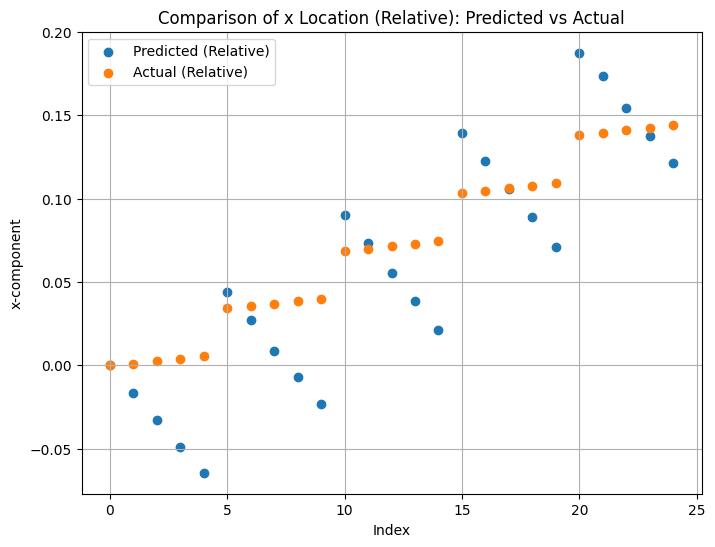

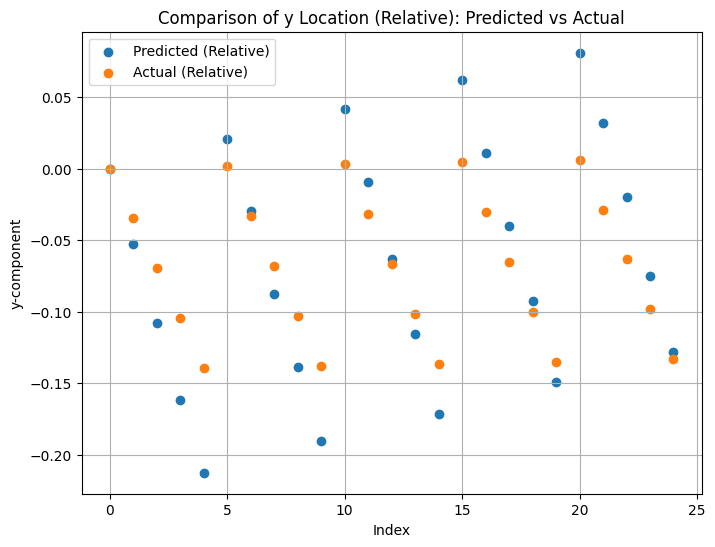

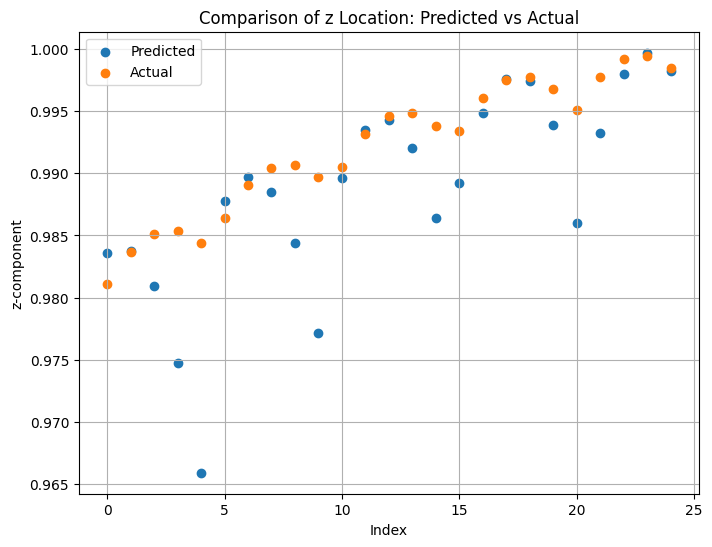

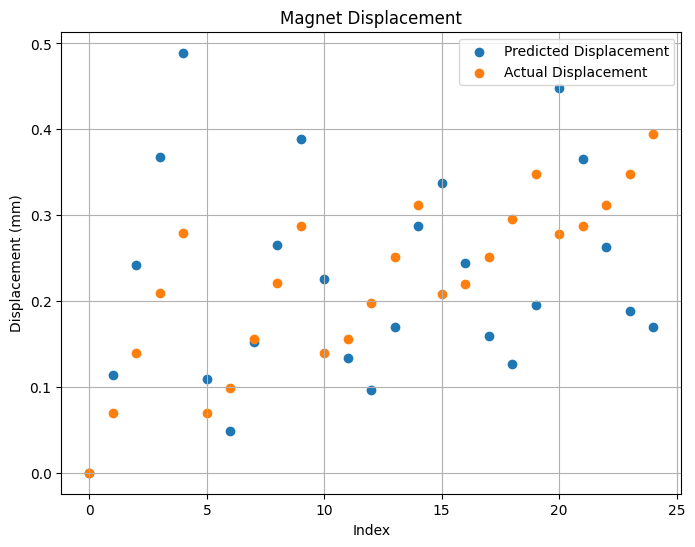

In [6]:
comparison_plot(actang, anglepred, axis='x', relative=True)
comparison_plot(actang, anglepred, axis='y', relative=True)
comparison_plot(actang, anglepred, axis='z', relative=False)
displacement_plot(locact, locpred)

In [8]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Cone(x=locpred[:,0], y=locpred[:,1], z=locpred[:,2], u=anglepred[:,0], v=anglepred[:,1], w=anglepred[:,2], 
                             sizemode="absolute", sizeref=10))

fig.update_layout(scene_camera_eye=dict(x=-0.76, y=1.8, z=0.92))

fig.show()